In [1]:
%env BUILD_MONAI=1
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=monai[all]

env: BUILD_MONAI=1


#### Setting env BUILD_MONAI=1 indicates that when calling the relevant Python modules, MONAI will prefer those extensions instead of the Pytorch/Python native implementations.

#### env BUILD_MONAI=1로 설정하면 관련 Python 모듈을 호출할 때 MONAI가 Pytorch/Python 기본 구현 대신 해당 확장을 선호함을 나타냅니다.

## import packages

In [2]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

import numpy as np
import torch
from torch.nn import MSELoss
import matplotlib.pyplot as plt
import os
import tempfile


print_config()
set_determinism(42)

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 8.4.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.30.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpxzh37h7r


In [4]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data
    if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])

MedNIST.tar.gz: 59.0MB [00:03, 19.8MB/s]                                        

2023-08-17 22:05:31,765 - INFO - Downloaded: /tmp/tmpxzh37h7r/MedNIST.tar.gz


2023-08-17 22:05:31,841 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-08-17 22:05:31,842 - INFO - Writing into directory: /tmp/tmpxzh37h7r.


Loading dataset: 100%|████████████████| 47164/47164 [00:00<00:00, 140683.01it/s]


 first training items:  [{'fixed_hand': '/tmp/tmpxzh37h7r/MedNIST/Hand/006070.jpeg', 'moving_hand': '/tmp/tmpxzh37h7r/MedNIST/Hand/006070.jpeg'}, {'fixed_hand': '/tmp/tmpxzh37h7r/MedNIST/Hand/008769.jpeg', 'moving_hand': '/tmp/tmpxzh37h7r/MedNIST/Hand/008769.jpeg'}, {'fixed_hand': '/tmp/tmpxzh37h7r/MedNIST/Hand/002885.jpeg', 'moving_hand': '/tmp/tmpxzh37h7r/MedNIST/Hand/002885.jpeg'}]


In [5]:
train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"]),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRanged(
            keys=["fixed_hand", "moving_hand"],
            a_min=0.0,
            a_max=255.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RandRotateD(keys=["moving_hand"], range_x=np.pi / 4, prob=1.0, keep_size=True, mode="bicubic"),
        RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
    ]
)

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


## Visualization of the training pairs

moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


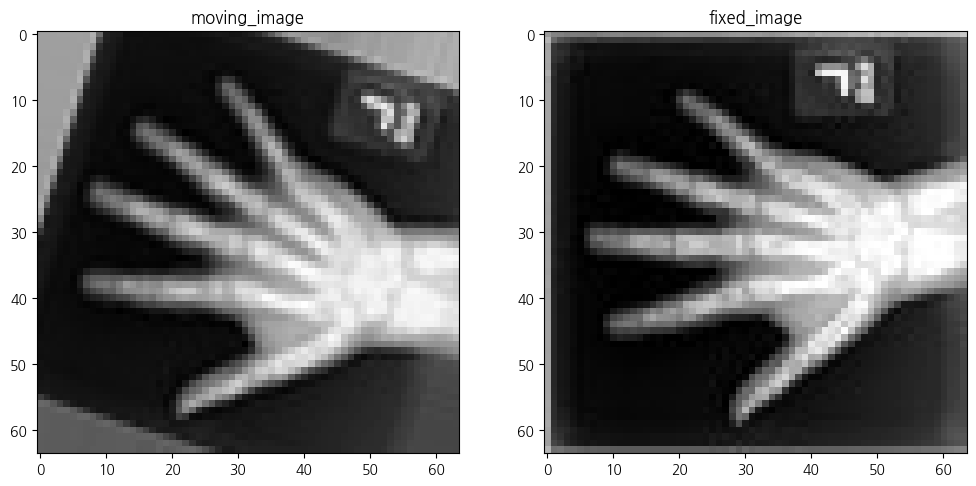

In [6]:
check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed_hand"][0][0]
moving_image = check_data["moving_hand"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()

## Create the traing pipelines

CacheDataset을 사용하여 학습 쌍을 캡처하고 학습 프로세스를 가속화합니다. 학습 데이터는 이미지 수준 아핀 변환 매개변수를 예측하는 GlobalNet에 공급됩니다. Warp 레이어가 초기화되고 훈련 및 추론에 모두 사용됩니다.

In [7]:
train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

Loading dataset: 100%|████████████████████| 1000/1000 [00:00<00:00, 1362.53it/s]


In [8]:
device = torch.device("cuda:0")
model = GlobalNet(
    image_size=(64, 64), spatial_dims=2, in_channels=2, num_channel_initial=16, depth=3  # moving and fixed
).to(device)


image_loss = MSELoss()


if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


## Training Loops

In [9]:
max_epochs = 200
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        moving = batch_data["moving_hand"].to(device)
        fixed = batch_data["fixed_hand"].to(device)
        ddf = model(torch.cat((moving, fixed), dim=1))
        pred_image = warp_layer(moving, ddf)

        loss = image_loss(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #       f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/200
epoch 1 average loss: 0.0582
----------
epoch 2/200
epoch 2 average loss: 0.0499
----------
epoch 3/200
epoch 3 average loss: 0.0478
----------
epoch 4/200
epoch 4 average loss: 0.0447
----------
epoch 5/200
epoch 5 average loss: 0.0447
----------
epoch 6/200
epoch 6 average loss: 0.0435
----------
epoch 7/200
epoch 7 average loss: 0.0421
----------
epoch 8/200
epoch 8 average loss: 0.0435
----------
epoch 9/200
epoch 9 average loss: 0.0397
----------
epoch 10/200
epoch 10 average loss: 0.0381
----------
epoch 11/200
epoch 11 average loss: 0.0378
----------
epoch 12/200
epoch 12 average loss: 0.0370
----------
epoch 13/200
epoch 13 average loss: 0.0377
----------
epoch 14/200
epoch 14 average loss: 0.0367
----------
epoch 15/200
epoch 15 average loss: 0.0356
----------
epoch 16/200
epoch 16 average loss: 0.0359
----------
epoch 17/200
epoch 17 average loss: 0.0334
----------
epoch 18/200
epoch 18 average loss: 0.0328
----------
epoch 19/200
epoch 19 average loss:

epoch 151 average loss: 0.0109
----------
epoch 152/200
epoch 152 average loss: 0.0107
----------
epoch 153/200
epoch 153 average loss: 0.0115
----------
epoch 154/200
epoch 154 average loss: 0.0117
----------
epoch 155/200
epoch 155 average loss: 0.0106
----------
epoch 156/200
epoch 156 average loss: 0.0098
----------
epoch 157/200
epoch 157 average loss: 0.0114
----------
epoch 158/200
epoch 158 average loss: 0.0122
----------
epoch 159/200
epoch 159 average loss: 0.0103
----------
epoch 160/200
epoch 160 average loss: 0.0100
----------
epoch 161/200
epoch 161 average loss: 0.0101
----------
epoch 162/200
epoch 162 average loss: 0.0113
----------
epoch 163/200
epoch 163 average loss: 0.0107
----------
epoch 164/200
epoch 164 average loss: 0.0114
----------
epoch 165/200
epoch 165 average loss: 0.0106
----------
epoch 166/200
epoch 166 average loss: 0.0108
----------
epoch 167/200
epoch 167 average loss: 0.0101
----------
epoch 168/200
epoch 168 average loss: 0.0120
----------
epoch 

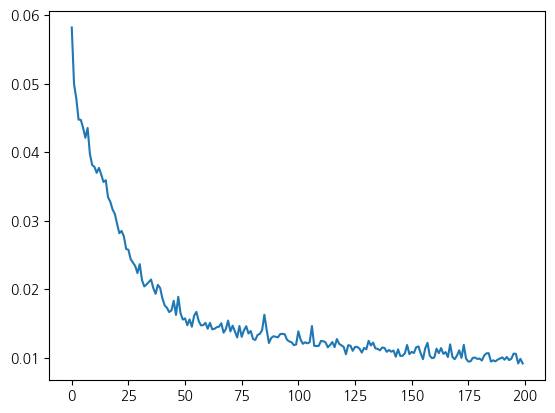

In [10]:
%matplotlib inline
plt.plot(epoch_loss_values)

## Visualise some validation results

In [11]:
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms, cache_rate=1.0, num_workers=0)

val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Loading dataset: 100%|██████████████████████| 500/500 [00:00<00:00, 1788.43it/s]


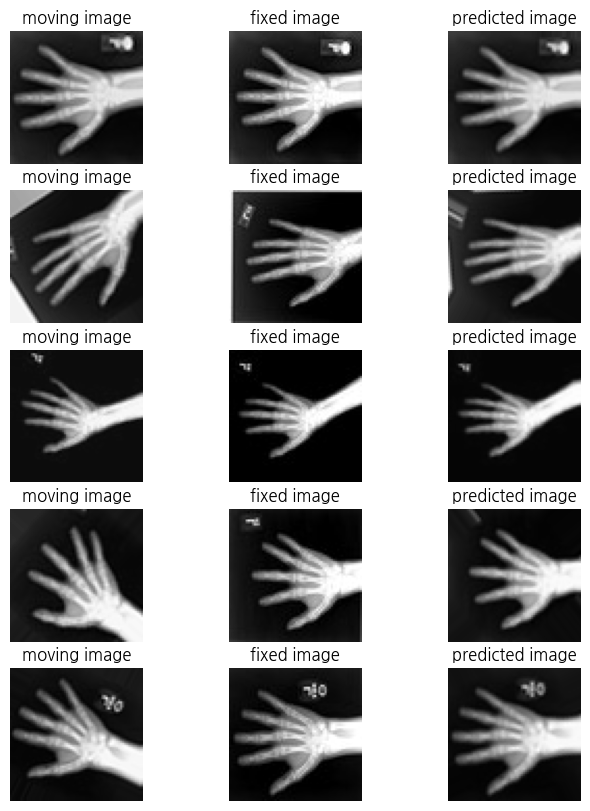

In [12]:
%matplotlib inline
batch_size = 5
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis("off")
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis("off")
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis("off")
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis("off")
plt.show()

### 